# Bussiness problem
A social media analytics team wants to automatically detect customer sentiment directed at brands or products. Understanding this sentiment can help marketing and product teams measure public perception and respond effectively.

In [4]:
#loading necessary libraries
import numpy as np
import pandas as pd
import re
import string 
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

<frozen importlib._bootstrap>:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 216 from C header, got 232 from PyObject


In [8]:
#Loading the dataset 
df = pd.read_csv("C:/Users/HP/Documents/NLP-models-for-twitter-sentiment-analysis--google-and-apple-products-/data/tweet_product_company.csv" , encoding='ISO-8859-1')
df.head(5)

,tweet_text,emotion_in_tweet_is_directed_at,is_there_an_emotion_directed_at_a_brand_or_product
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative emotion
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive emotion
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive emotion
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,Negative emotion
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Positive emotion


###  EDA AND Data Cleaning

In [ ]:
# Shape of dataset
df.shape

(9093, 3)

In [ ]:
# Column names
df.columns.tolist()

['tweet_text',
 'emotion_in_tweet_is_directed_at',
 'is_there_an_emotion_directed_at_a_brand_or_product']

In [15]:
# Check missing values
df.isnull().sum()

tweet_text                                               1
emotion_in_tweet_is_directed_at                       5802
is_there_an_emotion_directed_at_a_brand_or_product       0
dtype: int64

In [16]:
# Droping  rows where tweet_text 
df = df.dropna(subset=['tweet_text'])


In [19]:
# Filtering only Positive and Negative emotions
df= df[df['is_there_an_emotion_directed_at_a_brand_or_product'].isin(['Positive emotion','Negative emotion'])]

In [44]:
def create_binary_label(df, source_col, target_col='label', drop_neutral=False):
    """
    Create a binary label column in a DataFrame.
    
    Parameters:
    df (pd.DataFrame): The input DataFrame.
    source_col (str): Column name containing emotion labels.
    target_col (str): Name of the binary label column to create (default 'label').
    drop_neutral (bool): Whether to drop rows with neutral/unknown emotions. Default is False.
    
    Returns:
    pd.DataFrame: DataFrame with new binary label column.
    """
    mapping = {
        'Positive emotion': 1,
        'Negative emotion': 0,
    }

    df[target_col] = df[source_col].map(mapping)

    if drop_neutral:
        df = df[df[target_col] != -1].copy()

    return df


In [45]:
from collections import Counter
import nltk

nltk.download('punkt')

def get_most_common_words(df, text_col, top_n=20, lowercase=True, print_output=True):
    """
    Tokenizes text data and returns the most common words.

    Parameters:
    df (pd.DataFrame): DataFrame containing the text data.
    text_col (str): Name of the column containing text.
    top_n (int): Number of top frequent words to return. Default is 20.
    lowercase (bool): Whether to lowercase the text before tokenizing. Default is True.
    print_output (bool): Whether to print the results. Default is True.

    Returns:
    List of tuples: (word, frequency)
    """
    all_words = []

    for text in df[text_col].dropna():
        if lowercase:
            text = text.lower()
        tokens = nltk.word_tokenize(text)
        all_words.extend(tokens)

    word_freq = Counter(all_words)
    most_common = word_freq.most_common(top_n)

    if print_output:
        print(f"🔝 Top {top_n} Most Common Words:")
        for word, freq in most_common:
            print(f"{word}: {freq}")

    return most_common
top_words = get_most_common_words(df, text_col='tweet_text', top_n=20)


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\HP\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


🔝 Top 20 Most Common Words:
#: 5937
sxsw: 3686
.: 2609
@: 2535
mention: 2507
the: 1904
to: 1415
!: 1361
,: 1321
link: 1319
{: 1315
}: 1315
ipad: 1191
at: 1165
rt: 1075
apple: 1045
for: 1028
;: 993
&: 945
a: 938


#### After examining the top 20 most frequent words in the dataset, I noticed that many of them were non-informative tokens such as punctuation marks, links, mentions, and common stopwords like "the", "to", and "for". These do not contribute meaningfully to the sentiment analysis task. To ensure that the model focuses on the most relevant and meaningful words, I decided to clean the text by removing this noise. This will help improve the accuracy and interpretability of the models used later.


In [ ]:
import re
import string
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

# Download necessary NLTK data
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

# Initialize lemmatizer and stopwords
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

def tokenize_text(text):
    """
    Lowercase, remove URLs, mentions, hashtags, punctuation, and tokenize.
    """
    text = text.lower()
    text = re.sub(r'http\S+|www.\S+', '', text)           
    text = re.sub(r'@\w+|#\w+', '', text)                 
    text = re.sub(r'[{}0-9]'.format(string.punctuation), ' ', text)  
    tokens = nltk.word_tokenize(text)
    return tokens

def remove_stopwords(tokens):
    """
    Remove stopwords and non-alphabetic tokens.
    """
    return [word for word in tokens if word.isalpha() and word not in stop_words]

def lemmatize_tokens(tokens):
    """
    Lemmatize the tokens.
    """
    return [lemmatizer.lemmatize(word) for word in tokens]

def clean_text(text):
    """
    Full cleaning pipeline: tokenization → stopword removal → lemmatization → return string.
    """
    tokens = tokenize_text(text)
    tokens = remove_stopwords(tokens)
    tokens = lemmatize_tokens(tokens)
    return ' '.join(tokens)


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\HP\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\HP\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\HP\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


### Applying Text Cleaning

The `clean_text` function was applied to the `tweet_text` column to remove unwanted noise such as punctuation, stopwords, links, mentions, and hashtags. The cleaned and lemmatized text was stored in a new column called `cleaned_text`. This cleaned version of the tweets will be used for feature extraction and modeling.


In [47]:
import nltk
nltk.download('wordnet')
nltk.download('omw-1.4')
# Appling to tweet_text column
df['cleaned_text'] = df['tweet_text'].apply(clean_text)

# Showing cleaned version
df[['tweet_text', 'cleaned_text']].head(5)

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\HP\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\HP\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


,tweet_text,cleaned_text
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,g iphone hr tweeting dead need upgrade plugin ...
1,@jessedee Know about @fludapp ? Awesome iPad/i...,know awesome ipad iphone app likely appreciate...
2,@swonderlin Can not wait for #iPad 2 also. The...,wait also sale
3,@sxsw I hope this year's festival isn't as cra...,hope year festival crashy year iphone app
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,great stuff fri marissa mayer google tim reill...


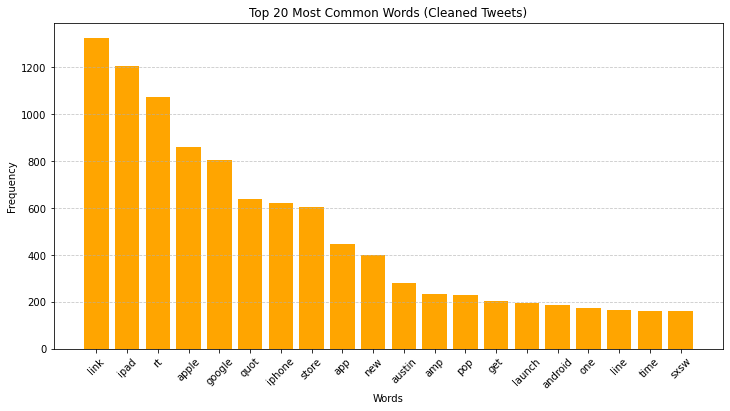

In [48]:
from collections import Counter
import matplotlib.pyplot as plt

# Combining  all cleaned words into a list
all_cleaned_words = ' '.join(df['cleaned_text']).split()

# Counting  most common cleaned words
cleaned_freq = Counter(all_cleaned_words).most_common(20)

# Converting  to DataFrame for plotting
cleaned_df = pd.DataFrame(cleaned_freq, columns=['word', 'frequency'])

# Plot
plt.figure(figsize=(12,6))
plt.bar(cleaned_df['word'], cleaned_df['frequency'], color='orange')
plt.title('Top 20 Most Common Words (Cleaned Tweets)')
plt.xlabel('Words')
plt.ylabel('Frequency')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


### Bar Plot – Sentiment by Brand (Apple vs Google)

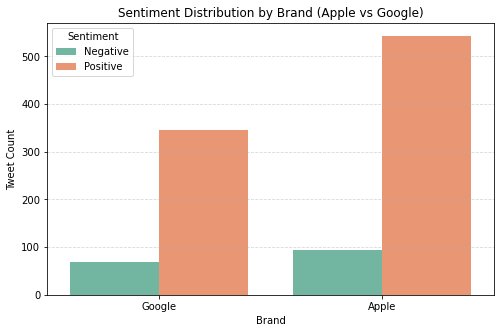

In [49]:
import seaborn as sns

# Filtering  rows with Apple or Google
brand_df = df[df['emotion_in_tweet_is_directed_at'].isin(['Apple', 'Google'])]

# Ploting  sentiment counts by brand
plt.figure(figsize=(8,5))
sns.countplot(data=brand_df, x='emotion_in_tweet_is_directed_at', hue='label', palette='Set2')

plt.title('Sentiment Distribution by Brand (Apple vs Google)')
plt.xlabel('Brand')
plt.ylabel('Tweet Count')
plt.legend(title='Sentiment', labels=['Negative', 'Positive'])
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.show()


### Feature Extraction and  Modeling Setup

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
# Features and target
X = df['cleaned_text']
y = df['label']

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

### TF-IDF Vectorizer

To train a machine learning model on text, we need to convert the tweets into numerical features. TF-IDF (Term Frequency-Inverse Document Frequency) transforms each tweet into a vector that highlights important words while reducing the weight of common ones. This representation helps the model focus on the most meaningful terms for sentiment classification.


In [51]:
# Initialize TF-IDF Vectorizer
tfidf = TfidfVectorizer(max_features=5000) 

# Fit and transform training data
X_train_tfidf = tfidf.fit_transform(X_train)

# Transform test data
X_test_tfidf = tfidf.transform(X_test)


### Model 1: Logistic Regression with TF-IDF and GridSearchCV

For our baseline model, we implemented a Logistic Regression classifier combined with TF-IDF vectorization using a Scikit-learn `Pipeline`. To optimize the model, we applied `GridSearchCV` with a 5-fold cross-validation strategy across various hyperparameters including `ngram_range`, `max_features`, regularization strength `C`, and penalty type.

In [83]:
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix

def build_and_train_pipeline(X_train, y_train):
    """
    Build a pipeline with TF-IDF and Logistic Regression, and perform Grid Search.
    Returns the best estimator.
    """

    # Pipeline steps
    pipeline = Pipeline([
        ('tfidf', TfidfVectorizer()),  # You can fine-tune max_features, ngram_range
        ('clf', LogisticRegression(solver='liblinear'))  # 'liblinear' works well for small datasets
    ])

    # Define hyperparameter grid
    param_grid = {
        'tfidf__max_features': [3000, 5000, 7000],
        'tfidf__ngram_range': [(1,1), (1,2)],
        'clf__C': [0.1, 1, 10],  # Regularization strength
        'clf__penalty': ['l1', 'l2']
    }

    # Grid Search
    grid = GridSearchCV(pipeline, param_grid, cv=5, n_jobs=-1, verbose=1, scoring='f1')
    grid.fit(X_train, y_train)

    print("Best parameters:")
    print(grid.best_params_)
    return grid.best_estimator_
best_lr_model = build_and_train_pipeline(X_train, y_train)

Fitting 5 folds for each of 36 candidates, totalling 180 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    3.9s
[Parallel(n_jobs=-1)]: Done 173 out of 180 | elapsed:   16.9s remaining:    0.6s


Best parameters:
{'clf__C': 10, 'clf__penalty': 'l2', 'tfidf__max_features': 7000, 'tfidf__ngram_range': (1, 2)}


[Parallel(n_jobs=-1)]: Done 180 out of 180 | elapsed:   18.8s finished


In [84]:
def evaluate_model(model, X_test, y_test):
    """
    Predict and print classification metrics.
    """
    y_pred = model.predict(X_test)
    print("\n Classification Report:\n", classification_report(y_test, y_pred))
    print(" Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
evaluate_model(best_lr_model, X_test, y_test)



 Classification Report:
               precision    recall  f1-score   support

           0       0.76      0.37      0.50       114
           1       0.89      0.98      0.93       596

    accuracy                           0.88       710
   macro avg       0.83      0.67      0.71       710
weighted avg       0.87      0.88      0.86       710

 Confusion Matrix:
 [[ 42  72]
 [ 13 583]]


### Insights
- The model performs well overall, especially on the dominant positive class.
- However, it struggles to identify negative sentiments (low recall), likely due to class imbalance in the dataset.


In [ ]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt

# Step 1: Initialize the model
nb_model = MultinomialNB()

# Step 2: Train on training data
nb_model.fit(X_train_tfidf, y_train)

# Step 3: Predict on test data
y_pred_nb = nb_model.predict(X_test_tfidf)

# Step 4: Evaluate the model
print(" MultinomialNB Classification Report:\n")
print(classification_report(y_test, y_pred_nb))



 MultinomialNB Classification Report:

              precision    recall  f1-score   support

           0       1.00      0.04      0.08       114
           1       0.85      1.00      0.92       596

    accuracy                           0.85       710
   macro avg       0.92      0.52      0.50       710
weighted avg       0.87      0.85      0.78       710



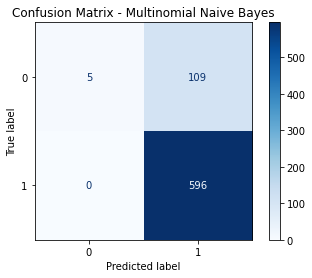

In [86]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Generate confusion matrix
cm = confusion_matrix(y_test, y_pred_nb)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)

# Plot it
disp.plot(cmap='Blues')
plt.title("Confusion Matrix - Multinomial Naive Bayes")
plt.show()


### Tuned MultinomialNB

Fitting 5 folds for each of 18 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    4.0s
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:    4.6s finished


 Best Parameters:
 {'nb__alpha': 0.1, 'tfidf__max_features': 7000, 'tfidf__ngram_range': (1, 2)}

 Classification Report:
               precision    recall  f1-score   support

           0       0.81      0.38      0.51       114
           1       0.89      0.98      0.94       596

    accuracy                           0.89       710
   macro avg       0.85      0.68      0.73       710
weighted avg       0.88      0.89      0.87       710



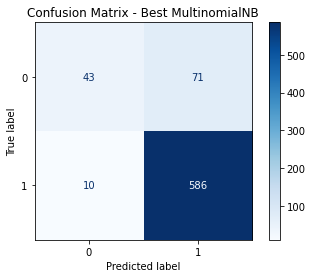

In [ ]:
# Step 1: Define the pipeline
nb_pipeline = Pipeline([
    ('tfidf', TfidfVectorizer()), 
    ('nb', MultinomialNB())
])

# Step 2: Set up parameter grid
param_grid = {
    'tfidf__max_features': [3000, 5000, 7000],
    'tfidf__ngram_range': [(1, 1), (1, 2)],
    'nb__alpha': [0.1, 0.5, 1.0]  # Laplace smoothing parameter
}

# Step 3: Initialize GridSearchCV
grid_search_nb = GridSearchCV(nb_pipeline, param_grid, cv=5, scoring='f1', n_jobs=-1, verbose=1)

# Step 4: Fit on training data
grid_search_nb.fit(X_train, y_train)

# Step 5: Evaluate on test data
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

# Best estimator
best_nb_model = grid_search_nb.best_estimator_
y_pred_nb = best_nb_model.predict(X_test)

# Report
print(" Best Parameters:\n", grid_search_nb.best_params_)
print("\n Classification Report:\n", classification_report(y_test, y_pred_nb))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred_nb)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues')
plt.title("Confusion Matrix - Best MultinomialNB")
plt.show()


In [ ]:
# Pipeline: TF-IDF + Random Forest
rf_pipeline = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('rf', RandomForestClassifier(random_state=42))
])

# Grid of hyperparameters
rf_param_grid = {
    'tfidf__max_features': [5000, 7000],
    'tfidf__ngram_range': [(1,1), (1,2)],
    'rf__n_estimators': [100, 200],
    'rf__max_depth': [None, 10, 20]
}

# GridSearch
rf_grid = GridSearchCV(rf_pipeline, rf_param_grid, cv=5, scoring='f1', n_jobs=-1, verbose=1)
rf_grid.fit(X_train, y_train)

# Best model
best_rf = rf_grid.best_estimator_
print("Best Parameters:\n", rf_grid.best_params_)

# Predict on test set
y_pred_rf = best_rf.predict(X_test)

# Evaluation
print("\n Random Forest Classification Report:\n")
print(classification_report(y_test, y_pred_rf))


Fitting 5 folds for each of 24 candidates, totalling 120 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   51.4s
[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed:  1.4min finished


Best Parameters:
 {'rf__max_depth': None, 'rf__n_estimators': 200, 'tfidf__max_features': 5000, 'tfidf__ngram_range': (1, 1)}

 Random Forest Classification Report:

              precision    recall  f1-score   support

           0       0.94      0.27      0.42       114
           1       0.88      1.00      0.93       596

    accuracy                           0.88       710
   macro avg       0.91      0.63      0.68       710
weighted avg       0.89      0.88      0.85       710

